# Introduction

Here we describe our analysis of the wikipedia traffic data.

# Imports

In [32]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [23]:
def smape(Y_predict, Y_test):
    if Y_predict.shape != Y_test.shape:
        raise ValueError('Expecting Y_predict shape == Y_test.shape, but NOT equal')
        return
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# Getting and Cleaning Data

We clean the data of NaN values by simply replacing each NaN value with the mean value of number of visits for each sample.

In [3]:
# Get the time series data.
data_df = pd.read_csv('train_2.csv')

print('data_df.shape = ', data_df.shape)
data_df.head()

data_df.shape =  (145063, 794)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [4]:
# Now fix NaN values in data_df.

means = data_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in data_df.columns:
    
    data_df[column].fillna(means, inplace = True)

data_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


# Time Features

Let's investigate using features derived from the time series for predicting future values of the time series.

## Splitting the Data

First, we need to split the time series data into past and future values.

In [5]:
futureT = 62
future_cols = data_df.columns[-futureT:]
past_cols = data_df.columns[:-futureT]

X_df = data_df.iloc[:, :-futureT]
Y_df = data_df.iloc[:, -futureT:]

X_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,28.0,26.0,29.0,21.0,23.0,23.0,32.0,34.0,21.0,24.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,24.0,18.0,193.0,26.0,62.0,127.0,104.0,20.0,29.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,8.0,7.0,3.0,5.0,4.0,4.0,5.0,5.0,0.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,12.0,17.0,15.0,12.0,11.0,12.0,10.0,22.0,21.0,30.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,12.0,12.0,17.0,16.0,12.0,10.0,21.0,14.0,9.0,12.0


Now let's split into training, validation, and test sets.

In [6]:
indices = train_test_split(X_df.index, Y_df.index, test_size = 0.33, random_state = 31)
X = {}
Y = {}
for name, inds in zip(['tv', 'test'], indices):
    X[name] = X_df.drop('Page', axis = 1).loc[inds]
    Y[name] = Y_df.loc[inds]

indices = train_test_split(X['tv'].index, Y['tv'].index, test_size = 0.33, random_state = 43)
for name, inds in zip(['train', 'valid'], indices):
    X[name] = X_df.drop('Page', axis = 1).loc[inds]
    Y[name] = Y_df.loc[inds]

for name in ['train', 'valid', 'test']:
    print('X ' + name + ' shape = ', X[name].shape,
          '\tY ' + name + ' shape = ', Y[name].shape)
    
X['train'].head()

X train shape =  (65118, 731) 	Y train shape =  (65118, 62)
X valid shape =  (32074, 731) 	Y valid shape =  (32074, 62)
X test shape =  (47871, 731) 	Y test shape =  (47871, 62)


,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30
122897,1879.000000,5639.000000,9545.000000,8663.000000,20317.000000,18077.000000,10069.000000,8128.000000,5766.000000,5538.000000,...,1137.0,1874.0,1097.0,1298.0,1617.0,1299.0,1173.0,1147.0,1068.0,952.0
138730,16.000000,15.000000,22.000000,26.000000,15.000000,22.000000,21.000000,19.000000,22.000000,21.000000,...,19.0,16.0,26.0,29.0,22.0,22.0,27.0,31.0,27.0,18.0
55662,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,175.514599,...,59.0,43.0,54.0,79.0,97.0,53.0,68.0,61.0,61.0,74.0
101069,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,740.498525,...,255.0,244.0,497.0,362.0,303.0,264.0,289.0,230.0,265.0,490.0
53806,340.000000,181.000000,438.000000,399.000000,325.000000,493.000000,1481.000000,294.000000,398.000000,372.000000,...,90.0,88.0,98.0,168.0,106.0,76.0,98.0,90.0,76.0,243.0


## Simple Benchmark Using Means

Let us develop a simple benchmark by just looking at a linear model based on the mean X value.

In [67]:
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', LinearRegression()) ])
model.fit(X['train'], Y['train'])
Y['predict'] = model.predict(X['valid'])
newsmape = smape(Y['predict'] + epsilon, Y['valid'])

results_df = pd.DataFrame([newsmape], columns = ['smape'], index = ['LinearMeans'])
results_df

,smape
LinearMeans,102.319842


## Transforming the data

Let's investigate how the mean Y value depends on the mean X value for the training data set.

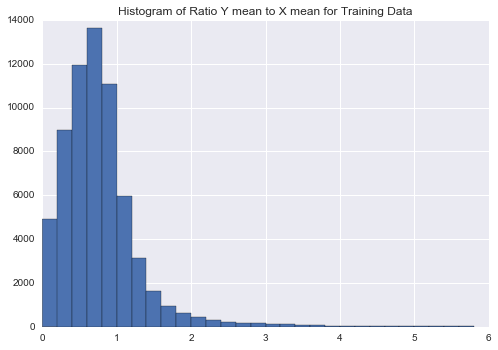

In [7]:
# Get histogram of mean Y values for training data.
epsilon = 1e-6

bins = np.arange(0, 6, 6 / 30)
values = Y['train'].mean(axis = 1) / (epsilon + X['train'].mean(axis = 1))
values.hist(bins = bins)
plt.title('Histogram of Ratio Y mean to X mean for Training Data')
plt.show()

So we see that the distribution of the ratio of the means are lop-sided. We can fix the lop sidedness using a logarithmic transform of the form z = np.log(C + x) for C a parameter. Now, note that we are using a SMAPE scoring function which prefers over estimates to under estimates. So, even for a Gaussian distribution of ratios about 1, it isn't ideal to just go with the average value; that is the reduction of L2 norms isn't ideal for optimizing a SMAPE score. We can try to fix this by adjusting C.

So let us search over values of C such that guessing the average value of the transform gives a good estimate. We use a linear model for the log values.

1 ,4 ,7 ,10 ,13 ,16 ,19 ,22 ,25 ,28 ,31 ,34 ,37 ,

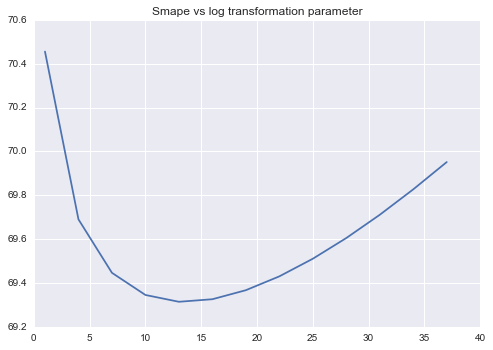

,smape
LinearMeans,102.319842
LinearMeansLog,69.951524


In [76]:
log_predictor = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                           ('linear', LinearRegression()) ])
search = np.arange(1, 40, 3)

results = []
for var in search:
    
    X['train_l'] = np.log(var + X['train'])
    Y['train_l'] = np.log(var + Y['train'])
    X['valid_l'] = np.log(var + X['valid'])

    log_predictor.fit(X['train_l'], Y['train_l'])
    Y['predict_l'] = log_predictor.predict(X['valid_l'])
    Y['predict'] = -var + np.exp(Y['predict_l'])
    newsmape = smape(epsilon + Y['predict'], Y['valid'])
    results.append(newsmape)
    print(var, ',', end = '')
    
plt.plot(search, results)
plt.title('Smape vs log transformation parameter')
plt.show()

So the optimal log transformation parameter seems to be about 12.5. We will use the transform z = np.log(12.5 + x). Let's construct the transforms of the different time series.

In [77]:
param = 12.5

for name in ['train', 'valid', 'test']:
    X[name + '_l'] = np.log(param + X[name])
    Y[name + '_l'] = np.log(param + Y[name])

Let's investigate how well the mean of the Y values correlates with X values.

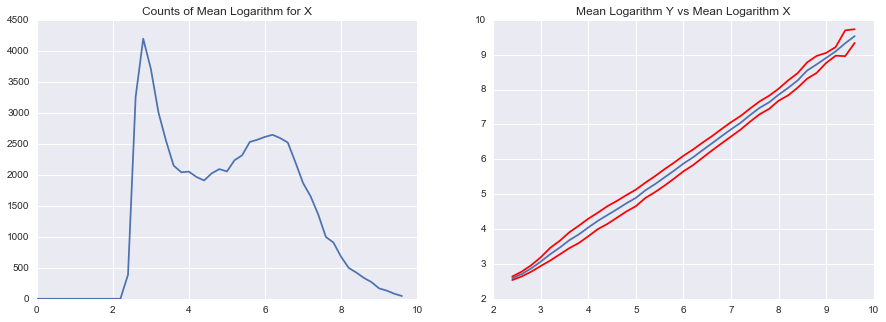

In [78]:
bins = np.arange(0, 10, 10 / 50)
cut = pd.cut(X['train_l'].mean(axis = 1), bins = bins)

plt.figure(figsize = (15, 5))
plt.subplot(121)
counts = Y['train_l'].mean(axis = 1).groupby(cut).count()
plt.plot(bins[:-1], counts.values)
plt.title('Counts of Mean Logarithm for X')

plt.subplot(122)
means = Y['train_l'].mean(axis = 1).groupby(cut).mean()
stds = Y['train_l'].std(axis = 1).groupby(cut).std()
plt.plot(bins[:-1], means.values)
plt.plot(bins[:-1], means.values + stds.values, color = 'red')
plt.plot(bins[:-1], means.values - stds.values, color = 'red')
plt.title('Mean Logarithm Y vs Mean Logarithm X')
plt.show()

So we see that there is a good linear relationship between the two. So let us now try a simple linear model.

In [79]:

log_predictor = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                           ('linear', LinearRegression()) ])

log_predictor.fit(X['train_l'], Y['train_l'])
Y['predict_l'] = log_predictor.predict(X['valid_l'])
Y['predict'] = -param + np.exp(Y['predict_l'])
newsmape = smape(epsilon + Y['predict'], Y['valid'])
print('smape = ', newsmape)

results_df.loc['LinearMeansLog'] = newsmape
results_df

smape =  69.3158584828


,smape
LinearMeans,102.319842
LinearMeansLog,69.315858


# Page Features

## Breaking Up Page Data

Now we break up the Page data into the name of the page, the wikipedia project, the access, and the agent. We store these features in a separate dataframe, page_df.

In [5]:
# Let's get information from Page data.

urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in data_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

page_df = pd.DataFrame(data = pageInfo[0], columns = ['name'])

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    page_df[name] = infoCol

page_df.head()

,name,project,access,agent
0,2NE1,9,0,3
1,2PM,9,0,3
2,3C,9,0,3
3,4minute,9,0,3
4,52_Hz_I_Love_You,9,0,3


To get a rough idea of how features extracted from the name affect our predictions, for each sample we will make use of ratios of the mean target value of visits over the mean value of visits in the domain. Now, we will need to make predictions for 62 days worth of data, so we treat the last 62 days in our time series of visits as target data.

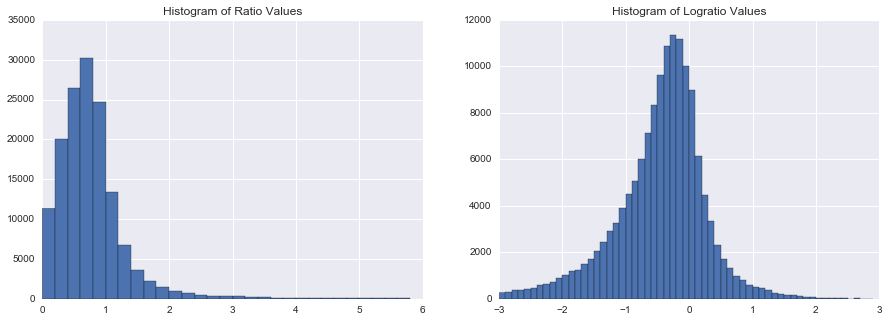

In [6]:
# Get the ratios of the means.

futureT = 62
epsilon = 1e-6

X_means = data_df.drop(['Page'], axis = 1).values[:, :-futureT].mean(axis = 1)
Y_means = data_df.drop(['Page'], axis = 1).values[:, -futureT:].mean(axis = 1)
ratios = Y_means / (epsilon + X_means)
page_df['ratios'] = ratios
page_df['logratios'] = np.log(epsilon + ratios)

doublefigsize = (15, 5)
plt.figure(figsize = doublefigsize)
plt.subplot('121')
page_df.ratios.hist(bins = np.arange(0, 6, 0.2))
plt.title('Histogram of Ratio Values')
plt.subplot('122')
page_df.logratios.hist(bins = np.arange(-3, 3, 0.1))
plt.title('Histogram of Logratio Values')
plt.show()

The histogram of ratio values is lop sided. We tried to fix it above by using the logarithm of the ratios. However, we see that the simple logarithm now has a tail on the left hand side. However, when we transform our ratios, it isn't necessarily best to transform the distribution into one resembling a Gaussian. Consider picking a value x to use as a prediction for a Gaussian distribution. For L2 regression, the optimal x to choose is the mean. However, for SMAPE, the optimal prediction should be below the median (which is the mean) since smape prefers over predictions to under predictions.

Let's us try to find a shift parameter such that the inverse transform of the mean value of the transformed distribution of Y_means is optimal for SMAPE score. This value should be related to optimizing smape score for L2 regression.

First let's see how the mean does as a predictor for the Y vals.

In [7]:
Y_vals = data_df.drop('Page', axis = 1).values[:, -futureT:]
Y_means = Y_vals.mean()
Y_means = np.full(Y_vals.shape, Y_means)
newsmape = smape(Y_vals, epsilon + Y_means)
print('Smape of just mean = ', newsmape)

Smape of just mean =  139.15566178


Now do a search over the optimal parameter param for a transformation z = np.log(param + y).

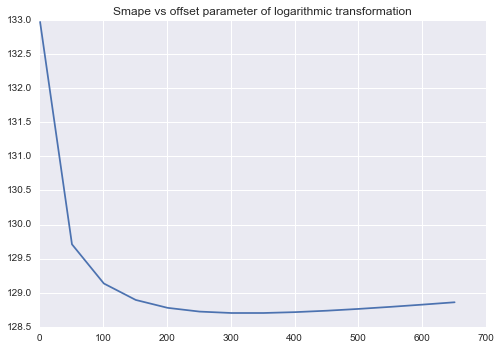

In [8]:
search = np.arange(1, 700, 50)

smapes = []
for param in search:
    Z_vals = np.log(param + Y_vals)
    Z_means = Z_vals.mean()
    Y_means = np.full(Y_vals.shape, -param + np.exp(Z_means))
    newsmape = smape(epsilon + Y_means, Y_vals)
    smapes.append(newsmape)
    
plt.plot(search, smapes)
plt.title('Smape vs offset parameter of logarithmic transformation')
plt.show()

So let's use the transform z = np.log(300 + y).

However, if we try training on the ratios of the Y vals to the mean of the X values, then we will need to use a different offset on the logarithm transformation.

Let's do a quick test of the smape for the Y_vals when predicting the ratio.

In [9]:
ratio_mean = page_df.ratios.mean()
Y_predict = (ratio_mean * X_means).reshape(-1, 1)
Y_predict = np.full(Y_vals.shape, Y_predict)
newsmape = smape(epsilon + Y_predict, Y_vals)
print('For simple ratio mean prediction, smape = ', newsmape)

For simple ratio mean prediction, smape =  81.3577548033


Now let's look at an offset search on logarithmic transformation of ratios.

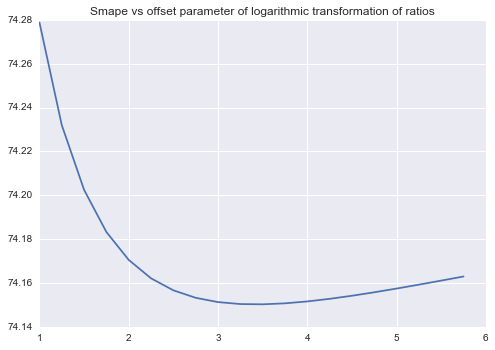

In [10]:
search = np.arange(1, 6, 0.25)

smapes = []
for param in search:
    Z_vals = np.log(param + page_df.ratios.values)
    Z_means = Z_vals.mean()
    ratio_predict = -param + np.exp(Z_means)
    Y_predict = (X_means * ratio_predict).reshape(-1,1)
    Y_predict = np.full(Y_vals.shape, Y_predict)
    newsmape = smape(epsilon + Y_predict, Y_vals)
    smapes.append(newsmape)
    
plt.plot(search, smapes)
plt.title('Smape vs offset parameter of logarithmic transformation of ratios')
plt.show()

So we see that the optimal constant to choose is about 3.5. So we go with z = np.log( 3.5 + Ratio ).

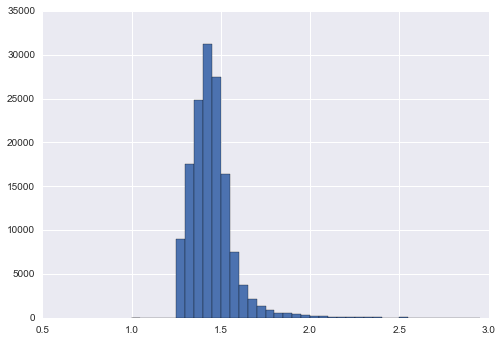

In [11]:
page_df.logratios = np.log(3.5 + page_df.ratios)

page_df.logratios.hist(bins = np.arange(1.0, 3, 0.05))
plt.show()

## Name Features

Now we look at creating features from the names.

### Number of Words in Name

Let's count the number of words in each name by counting the number of appearances of the character '_'.

In [12]:
# Let's count number of words in name.

numWords = []

for name in page_df['name']:
    num = len(re.split(r'_', name))
    numWords.append(num)
        
numWords = np.array(numWords)

page_df['numWords'] = numWords

Let's look at a histogram of word counts and how mean of log ratios depends on word counts.

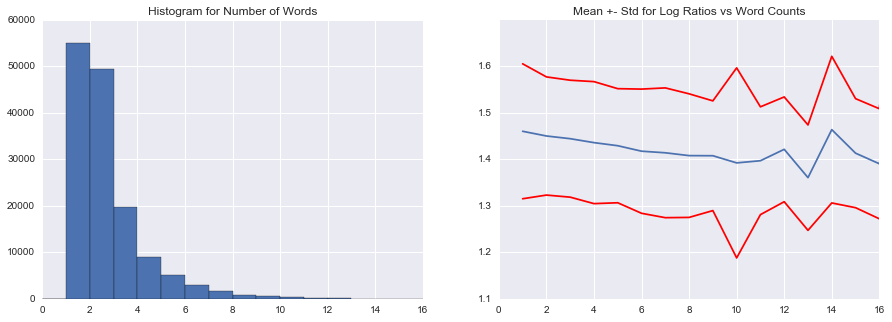

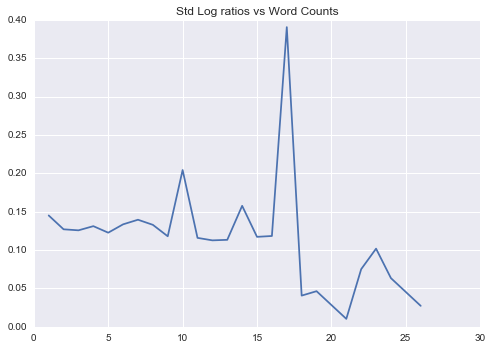

In [13]:
# Let's look at statistics for number of words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df['numWords'].hist(bins = np.arange(17))
plt.title('Histogram for Number of Words')

grouped_mean = page_df.groupby('numWords').mean()
grouped_std = page_df.groupby('numWords').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Word Counts')
ax = plt.gca()
ax.set_xlim([0, 16])
ax.set_ylim([1.1, 1.7])
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Word Counts')
plt.show()

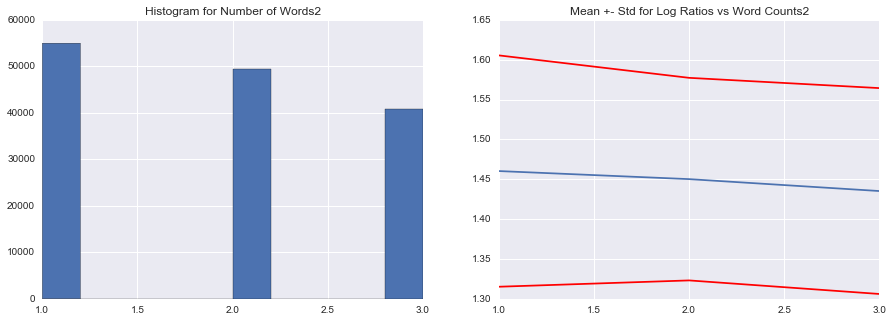

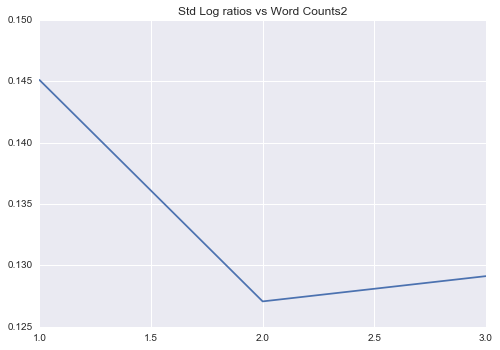

In [14]:
page_df['numWords2'] = page_df['numWords']
page_df.loc[page_df.numWords2 > 2, 'numWords2'] = 3

# Graph statistics for adjusted number of Words.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numWords2.hist()
plt.title('Histogram for Number of Words2')

grouped_mean = page_df.groupby('numWords2').mean()
grouped_std = page_df.groupby('numWords2').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Word Counts2')
ax = plt.gca()
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Word Counts2')
plt.show()

### Counts of Numbers in Name

Now let's look at counting the numbers that occur in each name.

In [15]:
# Let's look at number of Numbers.

numNums = []
for name in page_df['name']:
    num = len(re.split(r'\d+', name))
    numNums.append(num)
        
numNums = np.array(numNums)

page_df['numNums'] = numNums

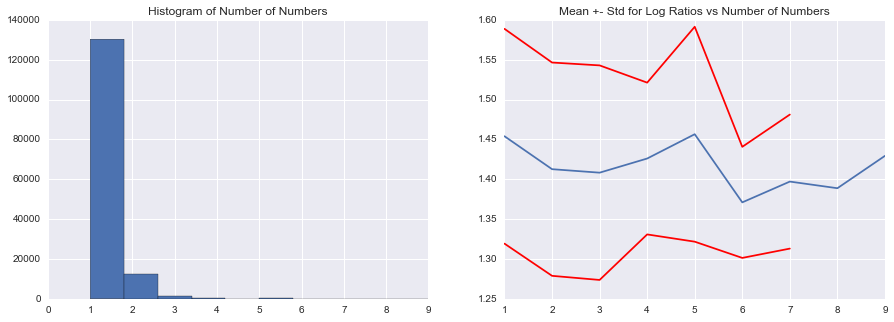

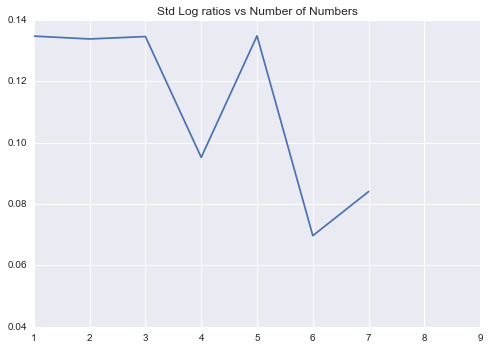

In [16]:
plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numNums.hist()
plt.title('Histogram of Number of Numbers')

grouped_mean = page_df.groupby('numNums').mean()
grouped_std = page_df.groupby('numNums').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Number of Numbers')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Number of Numbers')
plt.show()

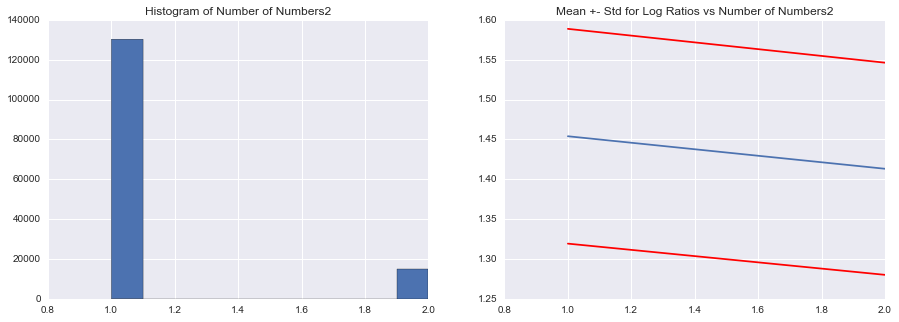

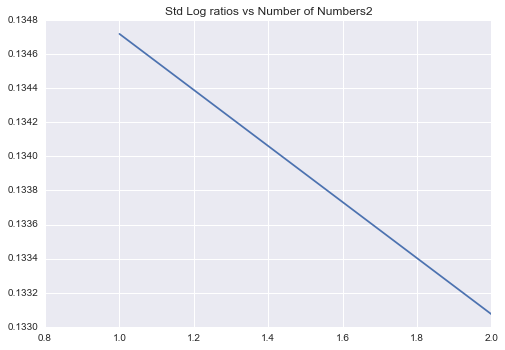

In [17]:
page_df['numNums2'] = page_df['numNums']
page_df.loc[page_df.numNums2 > 2, 'numNums2'] = 2

# Graph statistics for adjusted number of numbers.

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numNums2.hist()
plt.title('Histogram of Number of Numbers2')

grouped_mean = page_df.groupby('numNums2').mean()
grouped_std = page_df.groupby('numNums2').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Number of Numbers2')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Number of Numbers2')
plt.show()

### Size of First Number in Name

Now we extract the first number that appears in the name. We keep track of its size (i.e. itself).

In [18]:
# Let's get size of numbers inside names.

numSize = []
matches = []
for name in page_df['name']:
    match = re.search(r'\d+', name)
    matches.append(match)
    if match != None:
        num = float(match.group())
    else:
        num = 0
    numSize.append(num)

page_df['numSize'] = numSize

We look at a histogram of the positive numbers. We then adjust these values into two categories.

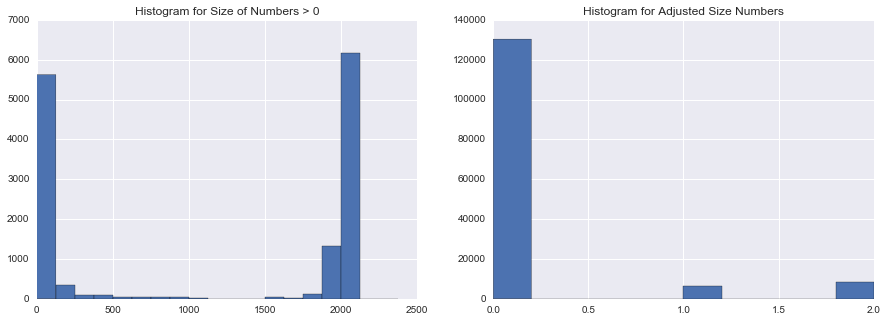

Proportion of Ajusted Number Size == 1 is  0.0437809779199
Proportion of Ajusted Number Size == 2 is  0.0579058753783
Mean Log Ratios by Adjusted Number Size
numSize2
0.0    1.453924
1.0    1.431765
2.0    1.398813
Name: logratios, dtype: float64


In [19]:
plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.numSize.hist(bins = np.arange(1, 2.5e3, 2.5e3 / 20))
plt.title('Histogram for Size of Numbers > 0')


page_df['numSize2'] = page_df.numSize
mask = page_df.numSize2 > 0
page_df.loc[mask & (page_df.numSize2 < 1250), 'numSize2'] = 1
page_df.loc[mask & (page_df.numSize2 > 1), 'numSize2'] = 2

plt.subplot(122)
page_df.numSize2.hist()
plt.title('Histogram for Adjusted Size Numbers')
plt.show()

print('Proportion of Ajusted Number Size == 1 is ', np.sum(page_df.numSize2 == 1) / len(page_df.numSize2))
print('Proportion of Ajusted Number Size == 2 is ', np.sum(page_df.numSize2 == 2) / len(page_df.numSize2))

print('Mean Log Ratios by Adjusted Number Size')
print(page_df.groupby('numSize2').mean().logratios)

### Acronym Count

Let's count the number of capital letters that occur in a sequence of two or more capital letters. This roughly gives a count of the number of letters that occur in acronyms.

In [20]:
# Let's look at number of consecutive capital letters (like in an acronym).

capNums = []
matches = []
for name in page_df['name']:
    match = re.findall(r'[A-Z][A-Z]+', name)
    matches.append(match)
    num = 0
    for s in match:
        num += len(s)
    capNums.append(num)
    
page_df['capNums'] = capNums

page_df.loc[[0, 4, 6, 8], ['name', 'capNums']]

,name,capNums
0,2NE1,2
4,52_Hz_I_Love_You,0
6,91Days,0
8,AKB48,3


Proportion with Acronym Count > 0 =  0.0506814280692


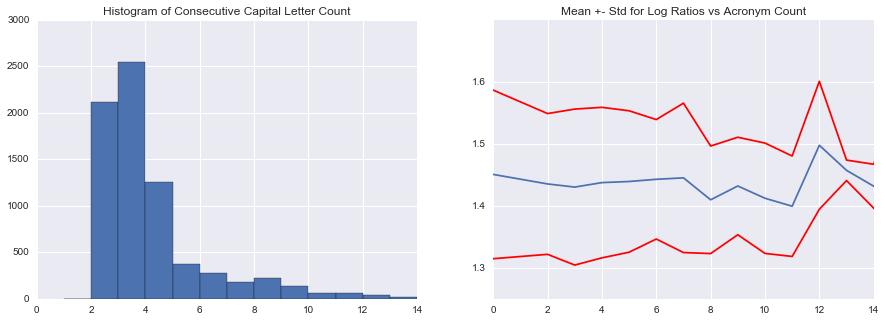

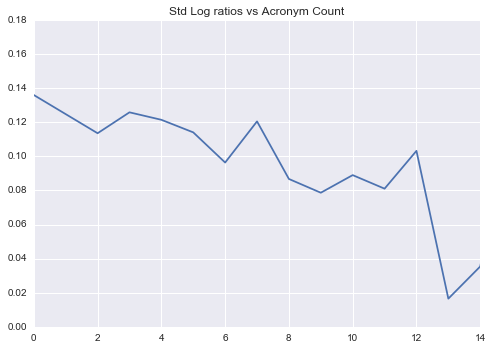

In [21]:
print('Proportion with Acronym Count > 0 = ', np.sum(page_df.capNums > 0) / len(page_df.capNums))

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.capNums.hist(bins = np.arange(1, 15))
plt.title('Histogram of Consecutive Capital Letter Count')

grouped_mean = page_df.groupby('capNums').mean()
grouped_std = page_df.groupby('capNums').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Acronym Count')
ax = plt.gca()
ax.set_xlim([0, 14])
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Acronym Count')
ax = plt.gca()
ax.set_xlim([0, 14])
plt.show()

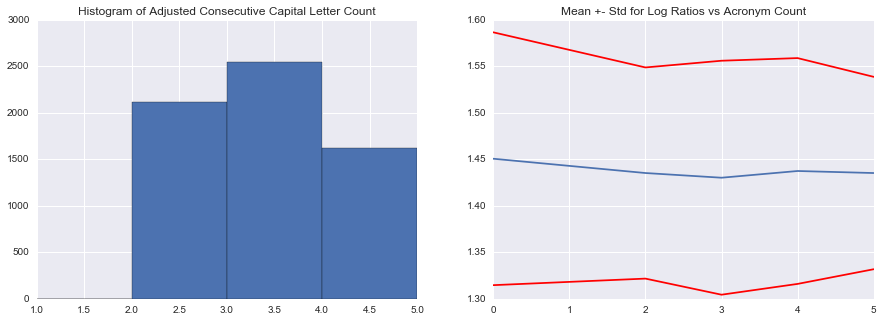

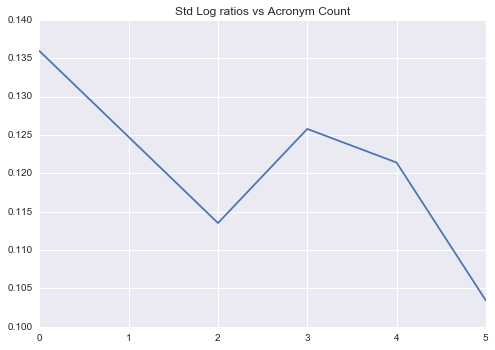

In [22]:
page_df['capNums2'] = page_df.capNums
page_df.loc[page_df.capNums2 > 5, 'capNums2'] = 5

plt.figure(figsize = doublefigsize)
plt.subplot(121)
page_df.capNums.hist(bins = np.arange(1, 6))
plt.title('Histogram of Adjusted Consecutive Capital Letter Count')

grouped_mean = page_df.groupby('capNums2').mean()
grouped_std = page_df.groupby('capNums2').std()

plt.subplot(122)
plt.plot(grouped_mean.index, grouped_mean.logratios)
plt.plot(grouped_std.index, grouped_mean.logratios + grouped_std.logratios, color = 'red')
plt.plot(grouped_std.index, grouped_mean.logratios - grouped_std.logratios, color = 'red')
plt.title('Mean +- Std for Log Ratios vs Acronym Count')
plt.show()

plt.plot(grouped_std.index, grouped_std.logratios)
plt.title('Std Log ratios vs Acronym Count')
plt.show()

### Largest Word Length

In [23]:
# Let's look at largest word length

wordLengths = []
for name in page_df['name']:
    words = re.split(r'_|\d+', name)
    matches.append(match)
    if words:
        lengths = np.array([len(x) for x in words])
        wordLengths.append(np.amax(lengths))
    else:
        wordLengths.append(0)
    
# put into data frame

page_df['wordLength'] = wordLengths
page_df.loc[[0, 4, 6, 8], ['name', 'wordLength']]

,name,wordLength
0,2NE1,2
4,52_Hz_I_Love_You,4
6,91Days,4
8,AKB48,3


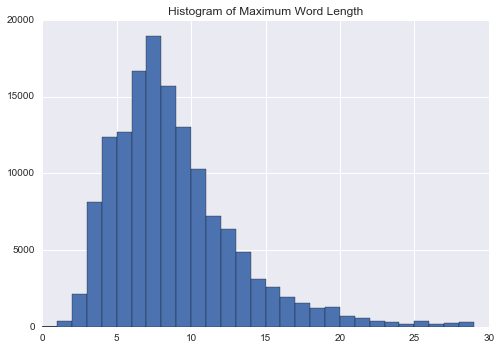

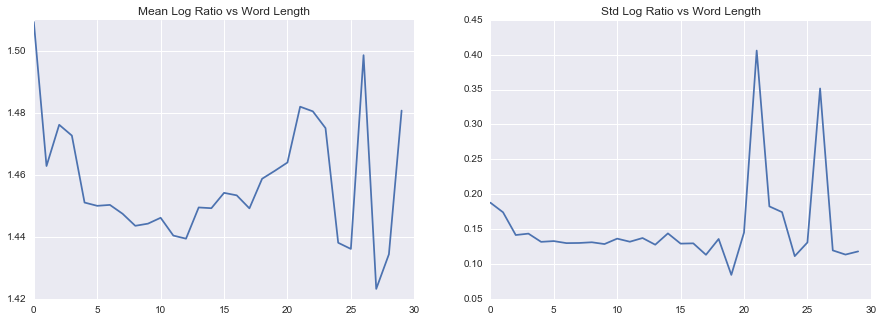

In [24]:
page_df.wordLength.hist(bins = np.arange(30))
plt.title('Histogram of Maximum Word Length')
plt.show()

grouped_name = page_df[page_df.wordLength < 30].groupby('wordLength')
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(grouped_name.mean().index, grouped_name.mean().logratios)
plt.title('Mean Log Ratio vs Word Length')

plt.subplot(122)
plt.plot(grouped_name.std().index, grouped_name.std().logratios)
plt.title('Std Log Ratio vs Word Length')
plt.show()

In [25]:
page_df['wordLength2'] = page_df.wordLength

### Collect Name Features

In [26]:
page_df.head()

,name,project,access,agent,ratios,logratios,numWords,numWords2,numNums,numNums2,numSize,numSize2,capNums,capNums2,wordLength,wordLength2
0,2NE1,9,0,3,1.049298,1.514973,1,1,3,2,2.0,1.0,2,2,2,2
1,2PM,9,0,3,1.309217,1.570534,1,1,2,2,2.0,1.0,2,2,2,2
2,3C,9,0,3,1.009199,1.506120,1,1,2,2,3.0,1.0,0,0,1,1
3,4minute,9,0,3,0.943928,1.491539,1,1,2,2,4.0,1.0,0,0,6,6
4,52_Hz_I_Love_You,9,0,3,1.178455,1.542968,5,3,2,2,52.0,1.0,0,0,4,4


In [27]:
name_features = ['project', 'access', 'agent', 'numWords2', 'numNums2', 'numSize2', 'capNums2', 'wordLength']
nameFeatures = page_df[name_features].values

# Divide Data into Training and Validation

In [28]:
timeSeries = data_df.drop(['Page'], axis = 1).values

In [29]:
# Now get data for training and validation.

nSamples, nName = nameFeatures.shape

X_all = timeSeries[:, :-futureT]
X_all = np.hstack((nameFeatures, X_all))
Y_all = timeSeries[:, -futureT:]

In [30]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
print('X_train.shape = ', X_train.shape, '\tY_train.shape = ', Y_train.shape, 
      '\tX_valid.shape = ', X_valid.shape, '\tY_valid.shape = ', Y_valid.shape)

X_train.shape =  (97192, 739) 	Y_train.shape =  (97192, 62) 	X_valid.shape =  (47871, 739) 	Y_valid.shape =  (47871, 62)


# Simple Name Features Models

## Benchmark of No Name Features

1   136.00 	4   128.09 	7   91.88 	10   75.53 	13   73.62 	16   74.36 	19   76.27 	



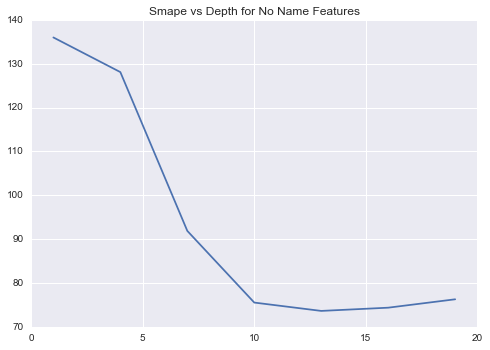

Best depth and smapes are:


,depth,smape
3,10.0,75.526828
4,13.0,73.623099
5,16.0,74.361171
6,19.0,76.274097


In [31]:
# Simply use the time series mean. This is a benchmark for no name features.

timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])

model = Pipeline([ ('data', timeTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(1, 20, 3)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns
for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth for No Name Features')
plt.show()

results_df = pd.DataFrame(np.stack([search, smapes], axis = -1), 
                          columns = ['depth', 'smape'])
print('Best depth and smapes are:')
results_df[results_df.smape < 80]

In [32]:
# Let's record the best result for this model.

best_df = pd.DataFrame( [ [results_df.depth[4], results_df.smape[4]] ],
                     columns = ['depth', 'smape'],
                     index = ['JustMean'])
best_df

,depth,smape
JustMean,13.0,73.623099


## Mean and Name Features

7   91.91 	9   77.40 	11   73.77 	13   72.01 	15   71.93 	17   72.06 	19   73.23 	

21   75.01 	23   77.88 	

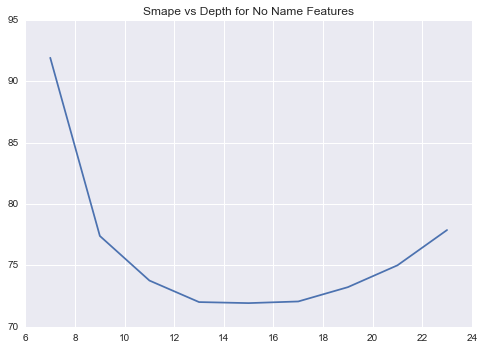

Best depth and smapes are:


,depth,smape
2,11.0,73.767084
3,13.0,72.013996
4,15.0,71.929806
5,17.0,72.063705
6,19.0,73.228934


In [33]:
# Simply use the time series mean and the name features.

timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])
nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(7, 25, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth for No Name Features')
plt.show()

results_df = pd.DataFrame(np.stack([search, smapes], axis = -1), 
                          columns = ['depth', 'smape'])
print('Best depth and smapes are:')
results_df[results_df.smape < 75]

In [34]:
# Let's record the best smape

best_df.loc['NameAndMean'] = [results_df.depth[4], results_df.smape[4]]

# Let's look at the improvement in smape.

improve = best_df.loc['JustMean', 'smape'] - best_df.loc['NameAndMean', 'smape']
improve = np.abs(improve) / best_df.loc['JustMean', 'smape']
print('Proportion of improvement since last model is ', '%.3f' % improve)

best_df

Proportion of improvement since last model is  0.023


,depth,smape
JustMean,13.0,73.623099
NameAndMean,15.0,71.929806


## Name Features and Log Transformation of X and Y

1   110.45 	4   73.29 	7   67.87 	10   66.35 	13   67.44 	16   70.78 	19   76.12 	



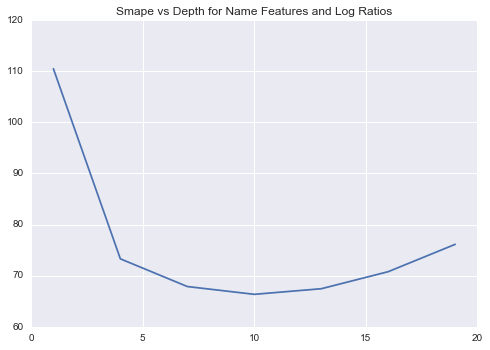

Best depth and smapes are:


,depth,smape
2,7.0,67.872113
3,10.0,66.348076
4,13.0,67.441528


In [35]:
# Simply use the time series mean. This is a benchmark for no name features.

param = 300

timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))) ])

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(1, 20, 3)

Z_train = np.log(param + Y_train)
Z_valid = np.log(param + Y_valid)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth for Name Features and Log Ratios')
plt.show()

results_df = pd.DataFrame(np.stack([search, smapes], axis = -1),
                          columns = ['depth', 'smape'])
print('Best depth and smapes are:')
results_df[results_df.smape < 70]

In [36]:
best_df.loc['logTransform'] = [results_df.depth[3], results_df.smape[3]]

improve = best_df.loc['logTransform', 'smape'] - best_df.loc['NameAndMean', 'smape']
improve = np.abs(improve) / best_df.loc['NameAndMean', 'smape']
print('Proportion of improvement from previous model is ', '%.3f' % improve)

best_df

Proportion of improvement from previous model is  0.078


,depth,smape
JustMean,13.0,73.623099
NameAndMean,15.0,71.929806
logTransform,10.0,66.348076


# Simple Window Mean Model

Now we consider adding features based on taking the mean inside windows of time, which should be located as close to the last time as possible. Note that we will keep the entire mean of all of the data, so we do not use windows covering the entire time domain. This is due to the fact that in such a case, the entire mean will have to be a specific average of these window means; so there will be a definite linear relationship between our features in this case.

Note that we will be taking the mean of the log transforms, as we found this gives a significant gain in SMAPE performance.

In [126]:
# Function for computing the window means. We specify the number of windows and every window has the same window size.

def window_means(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    cols = np.arange(windowSize)[:, np.newaxis] + windowSize * np.arange(nWindows)
    cols = nTimes - 1 - cols
    X_windows = X[:, cols]
    return X_windows.mean(axis = 1)

def window_transform(X_orthog):
    nSamples, nMeans = X_orthog.shape
    basis = np.zeros((nMeans, nMeans))
    basis[np.arange(1, nMeans), np.arange(nMeans - 1)] = 1
    basis[0] = np.full(nMeans, 1, dtype = 'float32') / np.sqrt(nMeans)
    for i in range(1, nMeans):
        projs = np.dot(basis[np.arange(i), :], basis[i])
        basis[i] -= np.dot(projs, basis[np.arange(i), :])
        basis[i] /= np.linalg.norm(basis[i])
    X_orthog = np.dot(X_orthog, basis.T)
    return X_orthog
    
def timeFeatures(X, nWindows):
    nSamples, nTimes = X.shape
    windowSize = int(nTimes / nWindows)
    means = window_means(X, nWindows, windowSize)
    features = window_transform(means)
    return features

def timeFeatures_notransform(X, nWindows):
    nSamples, nTimes = X.shape
    windowSize = int(nTimes / nWindows)
    means = window_means(X, nWindows, windowSize)
    allmeans = X.mean(axis = 1, keepdims = True)
    features = np.concatenate((allmeans, means), axis = 1)
    return features

In [41]:
nSamples, nTimes = X_train[:, nName:].shape
nWindows = int(nTimes / 62)
nWindows

11

nWindows, Correlation Norms:
2   0.03 	3   0.13 	4   0.16 	5   0.17 	6   0.20 	

7   0.20 	8   0.21 	9   0.22 	10   0.22 	11   0.22 	



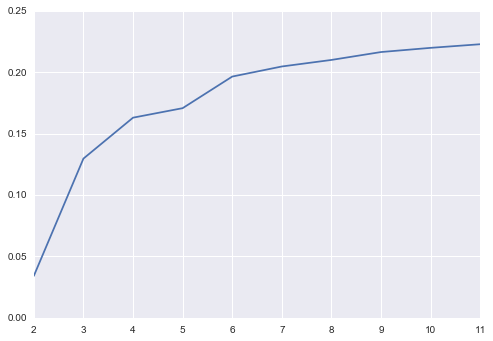

In [42]:
# Let's check linear correlations.

search = np.arange(2, 12, 1)

param = 300
Z_train = np.log(param + X_train[:, nName:])

nColumns = 5
columns = np.arange(len(search)) % nColumns
results = []

print('nWindows, Correlation Norms:' )
for var, col in zip(search, columns):
    
    tFeatures = timeFeatures(Z_train, var)

    corr_vars = tFeatures.T
    corr_matrix = np.corrcoef(corr_vars)
    
    def pairs():
        return ((i, j) for i in range(var) for j in range(var) if j > i)
    
    norm = np.sum([corr_matrix[i, j]**2 for i, j in pairs()])
    norm = norm / np.sum([1 for i, j in pairs()])
    norm = np.sqrt(norm)
    results.append(norm)
    
    print(var, ' ', '%.2f' % norm, '\t', end = '')
    
    if col == nColumns - 1:
        print('\n')
        
results = np.stack(results)
plt.plot(search, results)
plt.show()

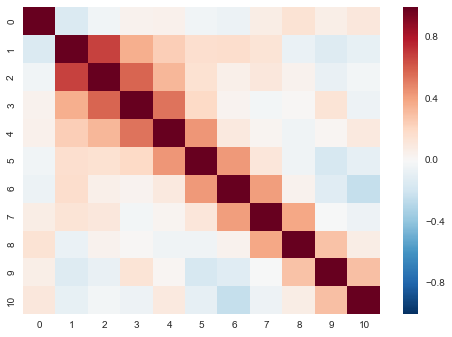

[ 0.14390487  0.68369843  0.68369843  0.58110214  0.5434612   0.43909532
  0.43059413  0.4168227   0.3895829   0.30377633  0.30377633]


In [63]:
# Let's check the linear correlations for 11 windows.

param = 300
Z_train = np.log(param + X_train[:, nName:])
tFeatures = timeFeatures(Z_train, 11)
corr_vars = tFeatures.T
corr_matrix = np.corrcoef(corr_vars)
sns.heatmap(corr_matrix)
plt.show()

cols = [[j for j in range(11) if i != j] for i in range(11)]
cols = np.array(cols)
rows = np.arange(11)[:, np.newaxis]
print(np.amax(np.abs(corr_matrix[rows, cols]), axis = 1))

In [44]:
print(corr_matrix[0])

[ 1.         -0.14390487 -0.03141117  0.04444094  0.04713312 -0.0341235
 -0.05777277  0.07238138  0.1406666   0.06906359  0.11605281]


In [127]:
# Let's look at statistics of how Y_train depends on tFeatures.

param = 300
Z_train = np.log(param + X_train[:, nName:])
tFeatures = timeFeatures_notransform(Z_train, 11)
Y_train_lm = np.log(param + Y_train).mean(axis = 1, keepdims = True)

print(tFeatures.shape)
means_df = pd.DataFrame(tFeatures, columns = ['means' + str(i) for i in range(12)])
means_df['ylog'] = Y_train_lm
means_df.head()

(97192, 12)


,means0,means1,means2,means3,means4,means5,means6,means7,means8,means9,means10,means11,ylog
0,5.938039,5.863755,5.939723,6.049287,5.927248,5.964923,5.953484,6.042295,6.107715,5.860243,5.909066,5.717681,5.875286
1,5.931719,5.953593,6.330794,5.903072,5.927378,5.895547,5.853165,5.894995,5.884545,5.869161,5.878920,5.866443,5.865712
2,5.750869,5.751649,5.767420,5.755629,5.750597,5.772196,5.776603,5.734820,5.737806,5.735090,5.734194,5.741134,5.874542
3,7.810730,7.585201,7.750735,7.536949,7.534325,7.602573,8.122769,8.023828,7.970450,7.889515,7.874028,8.008760,7.519982
4,5.956966,5.915842,5.930944,5.944299,6.024010,5.942881,5.950840,5.974070,5.981601,5.965026,5.955119,5.943834,5.907424


means0 max =  16.8607094656 	means0 min =  5.70378247466


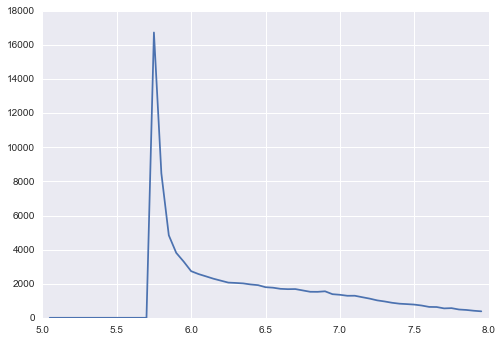

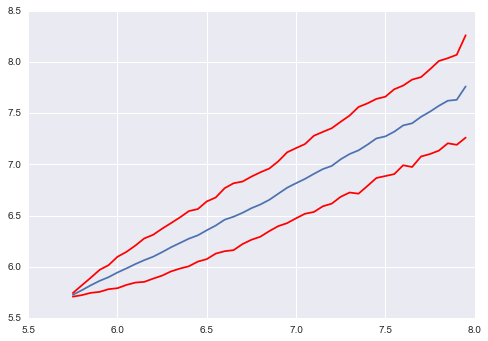

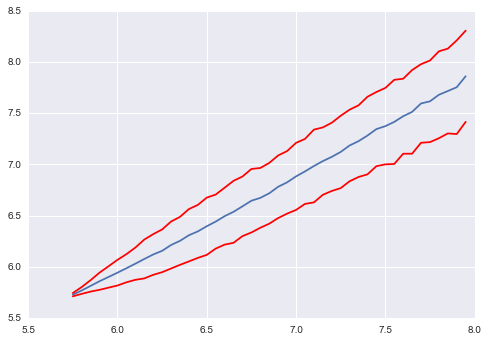

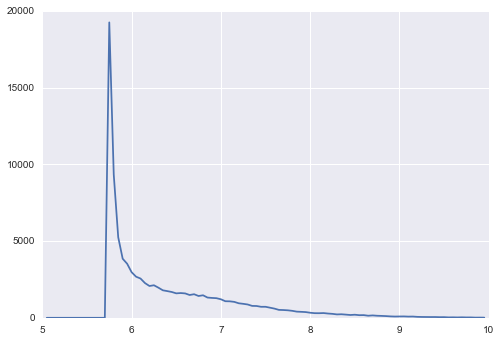

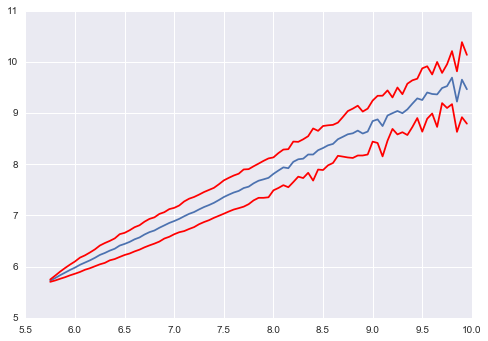

In [142]:
print('means0 max = ', np.amax(means_df.means0), '\tmeans0 min = ', np.amin(means_df.means0))
bins = np.arange(5, 8, 0.05)
cut = pd.cut(means_df.means0, bins = bins)

grouped_df = means_df.groupby(cut).count()
plt.plot(bins[1:], grouped_df.ylog.values)
plt.show()

means = means_df.groupby(cut).mean().ylog
std = means_df.groupby(cut).std().ylog
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + std, color = 'red')
plt.plot(bins[1:], means - std, color = 'red')
plt.show()

means = means_df.groupby(cut).mean().means1
std = means_df.groupby(cut).std().means1
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + std, color = 'red')
plt.plot(bins[1:], means - std, color = 'red')
plt.show()

bins = np.arange(5, 10, 0.05)
cut = pd.cut(means_df.means1, bins = bins)

grouped_df = means_df.groupby(cut).count()
plt.plot(bins[1:], grouped_df.ylog.values)
plt.show()

means = means_df.groupby(cut).mean().ylog
std = means_df.groupby(cut).std().ylog
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + std, color = 'red')
plt.plot(bins[1:], means - std, color = 'red')
plt.show()



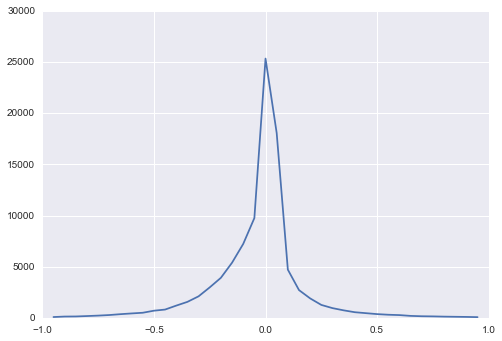

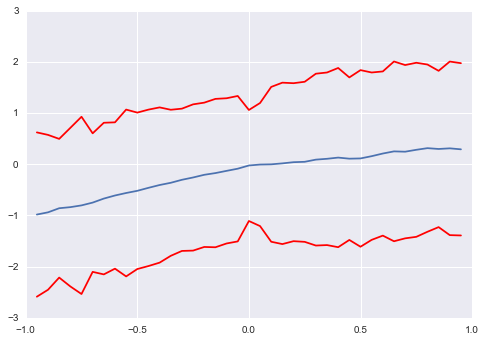

In [146]:
bins = np.arange(-1, 1, 0.05)
cut = pd.cut(means_df.means1 - means_df.means0, bins = bins)

grouped_df = means_df.groupby(cut).count()
plt.plot(bins[1:], grouped_df.ylog.values)
plt.show()

means = means_df.groupby(cut).mean().ylog - means_df.groupby(cut).mean().means0
std = means_df.groupby(cut).std().ylog + means_df.groupby(cut).std().means0
plt.plot(bins[1:], means)
plt.plot(bins[1:], means + std, color = 'red')
plt.plot(bins[1:], means - std, color = 'red')
plt.show()

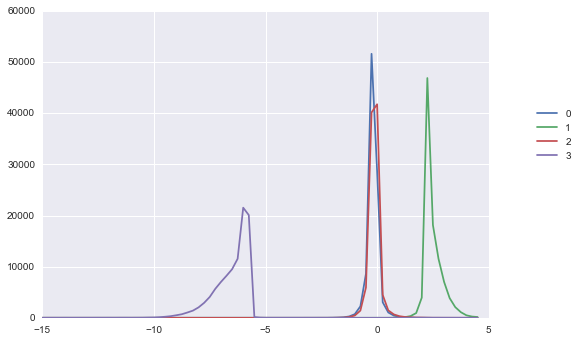

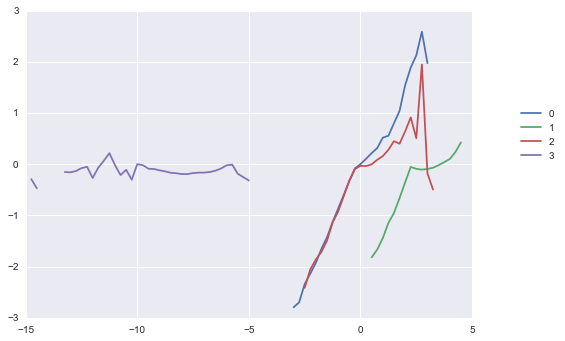

In [166]:
bins = np.arange(-15, 5, 0.25)

search = np.arange(0, np.pi, np.pi / 4)

means = []
counts = []
for var in search:
    comb = means_df.means1 * np.cos(var) + means_df.means2 * np.sin(var)
    cut = pd.cut(comb - means_df.means0, bins = bins)

    newcount = means_df.groupby(cut).count().ylog
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.ylog - grouped_df.means0
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend([i for i in range(len(search))], loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend([i for i in range(len(search))], loc = (1.1, 0.5))
plt.show()

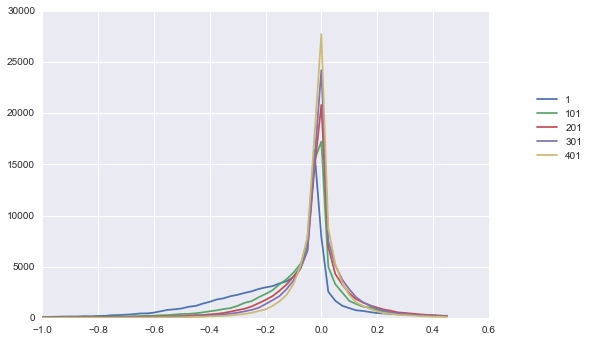

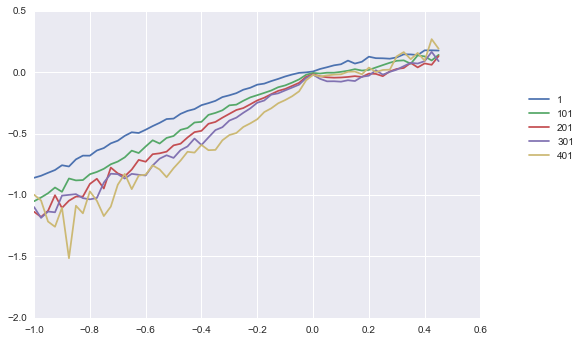

In [193]:
# Try looking at a search on window size for a single window mean.

bins = np.arange(-1, 0.5, 0.025)

param = 300
search = np.arange(1, 451, 100)

means = []
counts = []
Z_train = np.log(param + X_train[:, nName:])
Y_train_lm = np.log(param + Y_train).mean(axis = 1, keepdims = True)
all_mean = Z_train.mean(axis = 1, keepdims = True)
means_df = pd.DataFrame(np.concatenate((Y_train_lm, all_mean), axis = 1), columns = ['ylog', 'allmean'])

for var in search:
    means_df['windmean'] = Z_train[:, -var:].mean(axis = 1, keepdims = True)
    cut = pd.cut(means_df.windmean - means_df.allmean, bins = bins)

    newcount = means_df.groupby(cut).count().ylog
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.ylog - grouped_df.allmean
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

In [45]:
print(corr_matrix[1])

removed = [2, 4, 6, 8, 10]
cols = [[j for j in range(11) if i != j and j not in removed] for i in range(11) if i not in removed]
cols = np.array(cols)
rows = [i for i in np.arange(11) if i not in removed]
rows = np.array(rows)[:, np.newaxis]
print(np.amax(np.abs(corr_matrix[rows, cols]), axis = 1))
print(corr_matrix[3])

[-0.14390487  1.          0.68369843  0.36387186  0.24345505  0.16534024
  0.17656914  0.13587807 -0.06672483 -0.13121781 -0.08227727]
[ 0.14390487  0.36387186  0.36387186  0.20242084  0.13587807  0.16555163]
[ 0.04444094  0.36387186  0.58110214  1.          0.5434612   0.20242084
  0.03666923 -0.02787225  0.00986075  0.135673   -0.05097626]


[0, 1]
7   64.18 	9   62.36 	11   61.81 	13   62.44 	15   64.46 	17   67.50 	19   71.17 	



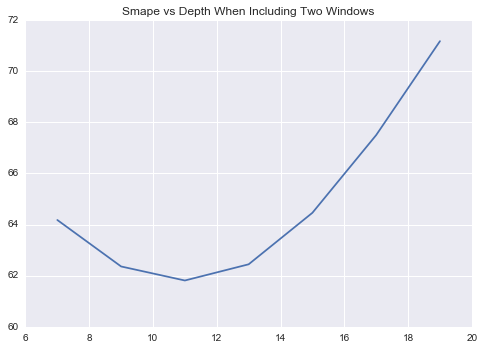

Best depth and smapes are:


,depth,smapes
1,9,62.359111
2,11,61.810476
3,13,62.443850


In [46]:
# Now we look at a depth first search.
param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures3', FunctionTransformer(timeFeatures,
                                                                 kw_args = {'nWindows' : 11})),
                             ('dropTransformed', FunctionTransformer(lambda X : X[:, colsToKeep]))])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(7, 20, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

Z_train = np.log(param + Y_train)
for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth When Including Two Windows')
plt.show()

print('Best depth and smapes are:')
results_df = pd.DataFrame(search, columns = ['depth'])
results_df['smapes'] = smapes

results_df[results_df.smapes < 63]

[0, 1]
2   64.99 	3   64.60 	4   63.72 	5   63.14 	6   62.70 	7   62.36 	8   62.11 	

9   61.88 	10   61.86 	11   61.83 	

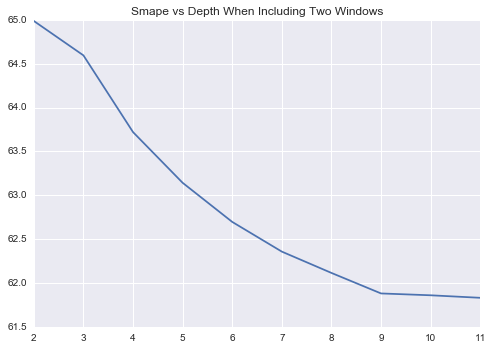

Best depth and smapes are:


,depth,smapes
4,6,62.696182
5,7,62.357454
6,8,62.114461
7,9,61.880483
8,10,61.859434
9,11,61.830670


In [44]:
# Now we look at a depth first search.
param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures3', FunctionTransformer(timeFeatures,
                                                                 kw_args = {'nWindows' : 3})),
                             ('dropTransformed', FunctionTransformer(lambda X : X[:, colsToKeep]))])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 11)) ])

search = np.arange(2, 12, 1)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

Z_train = np.log(param + Y_train)
for var, col in zip(search, columns):
    model.set_params(data__time__timeFeatures3__kw_args = {'nWindows' : var})
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(var, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth When Including Two Windows')
plt.show()

print('Best depth and smapes are:')
results_df = pd.DataFrame(search, columns = ['depth'])
results_df['smapes'] = smapes

results_df[results_df.smapes < 63]

In [45]:
best_df.loc['Windows'] = [results_df.depth[7], results_df.smapes[7]]

improve = best_df.loc['Windows', 'smape'] - best_df.loc['logTransform', 'smape']
improve = np.abs(improve) / best_df.loc['logTransform', 'smape']
print('Proportion of improvement from previous model is ', '%.3f' % improve)

best_df

Proportion of improvement from previous model is  0.067


,depth,smape
JustMean,13.0,73.623099
NameAndMean,15.0,71.929806
logTransform,10.0,66.348076
Windows,9.0,61.880483


## Linear Effects

In [46]:
# Only keep the first two mean transform features.
def timeFeatures2(X, nWindows, linSize):
    nSamples, nTimes = X.shape
    windowSize = int(nTimes / nWindows)
    means = window_means(X, nWindows, windowSize)
    features = window_transform(means)[:, :2]
    linear = np.arange(linSize) - (linSize - 1) / 2
    linear /= np.linalg.norm(linear)
    linear = np.dot(X[:, -linSize:], linear).reshape(-1,1)
    features = np.concatenate((features, linear), axis = 1)
    return features


Linear Window Size, Correlation Norms:
62   -0.151 -0.062 	67   -0.141 -0.043 	72   -0.127 -0.041 	77   -0.130 -0.018 	82   -0.101 0.009 	

87   -0.095 0.048 	92   -0.102 0.088 	97   -0.122 0.127 	

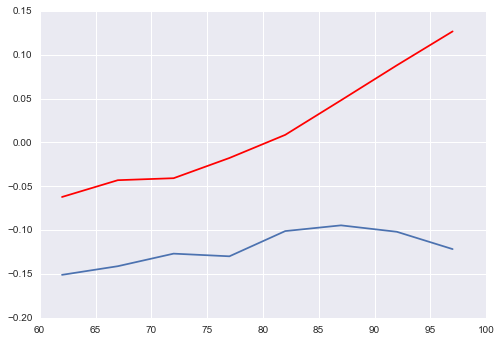

In [47]:
# Let's check linear correlations.

search = np.arange(62, 100, 5)

param = 300
Z_train = np.log(param + X_train[:, nName:])

nColumns = 5
columns = np.arange(len(search)) % nColumns
results = []

print('Linear Window Size, Correlation Norms:' )
for var, col in zip(search, columns):
    
    tFeatures = timeFeatures2(Z_train, 9, var)

    corr_vars = tFeatures.T
    corr_matrix = np.corrcoef(corr_vars)
    
    def pairs():
        return [(0,2), (1,2)]
    
    newresult = [corr_matrix[0, 2], corr_matrix[1,2]]
    results.append(newresult)
    
    print(var, ' ', '%.3f' % newresult[0], '%.3f' % newresult[1], '\t', end = '')
    
    if col == nColumns - 1:
        print('\n')
        
results = np.stack(results)
plt.plot(search, results[:, 0])
plt.plot(search, results[:, 1], color = 'red')
plt.show()

In [48]:
# Now we look at a depth first search.
param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'nWindows' : 9, 'linSize' : 80})) ])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

search = np.arange(7, 20, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

Z_train = np.log(param + Y_train)
for depth, col in zip(search, columns):
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth When Including Two Windows')
plt.show()

print('Best depth and smapes are:')
results_df = pd.DataFrame(search, columns = ['depth'])
results_df['smapes'] = smapes

results_df[results_df.smapes < 63]

[0, 1]
7   64.31 	9   62.80 	11   61.88 	

KeyboardInterrupt: 

In [ ]:
# Now we look at feature importance.

param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'nWindows' : 9, 'linSize' : 80})) ])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model = Pipeline([ ('data', dataTransformer),
                   ('tree', DecisionTreeRegressor(max_depth = 11)) ])

Z_train = np.log(param + Y_train)
model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = -param + np.exp(Z_predict)
newsmape = smape(epsilon + Y_predict, Y_valid)
smapes = np.append(smapes, newsmape)
print('%.2f' % newsmape, '\t', end = '')

In [ ]:
importances = model.named_steps['tree'].feature_importances_
print(importances)

plt.plot(importances)
plt.show()

important_ind = np.arange(len(importances))[importances > 1e-3]
#important_ind = important_ind[np.newaxis, :]
print(important_ind)
print(X_train[:, important_ind].shape)

In [ ]:
# Now we look at feature importance.

param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'nWindows' : 9, 'linSize' : 80})) ])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model2 = Pipeline([ ('data', dataTransformer),
                    ('dropUnimportant', FunctionTransformer(lambda X : X[:, important_ind ])),
                   ('tree', DecisionTreeRegressor(max_depth = 11)) ])

Z_train = np.log(param + Y_train)
model2.fit(X_train, Z_train)
Z_predict = model2.predict(X_valid)
Y_predict = -param + np.exp(Z_predict)
newsmape = smape(epsilon + Y_predict, Y_valid)
smapes = np.append(smapes, newsmape)
print('%.2f' % newsmape, '\t', end = '')

In [ ]:
importances = model2.named_steps['tree'].feature_importances_
print(importances)

plt.plot(importances)
plt.show()

important_ind2 = np.arange(len(importances))[importances > 1e-2]
#important_ind = important_ind[np.newaxis, :]
print(important_ind2)

In [ ]:
# Now we look at feature importance.

param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'nWindows' : 9, 'linSize' : 80})) ])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model3 = Pipeline([ ('data', dataTransformer),
                    ('dropUnimportant', FunctionTransformer(lambda X : X[:, important_ind ])),
                    ('dropUnimportant2', FunctionTransformer(lambda X : X[:, important_ind2 ])),
                   ('tree', DecisionTreeRegressor(max_depth = 11)) ])

Z_train = np.log(param + Y_train)
model3.fit(X_train, Z_train)
Z_predict = model3.predict(X_valid)
Y_predict = -param + np.exp(Z_predict)
newsmape = smape(epsilon + Y_predict, Y_valid)
smapes = np.append(smapes, newsmape)
print('%.2f' % newsmape, '\t', end = '')

In [ ]:
# Let's drop features with importance less than 1e-3.

param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'nWindows' : 9, 'linSize' : 80})) ])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model2 = Pipeline([ ('data', dataTransformer),
                   ('dropUnimportant', FunctionTransformer(lambda X : X[:, important_ind ])),
                   ('tree', DecisionTreeRegressor(max_depth = 11)) ])

search = np.arange(7, 20, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

Z_train = np.log(param + Y_train)
for depth, col in zip(search, columns):
    model2.set_params(tree__max_depth = depth)
    model2.fit(X_train, Z_train)
    Z_predict = model2.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth When Including Two Windows')
plt.show()

print('Best depth and smapes are:')
results_df = pd.DataFrame(search, columns = ['depth'])
results_df['smapes'] = smapes

results_df[results_df.smapes < 63]

In [ ]:
# Let's drop features with importance less than 1e-3.

param = 300
colsToKeep = [0, 1]
print(colsToKeep)
colsToKeep = np.array(colsToKeep)
timeTransformer = Pipeline([ ('dropNames', FunctionTransformer(lambda X : X[:, nName:])),
                             ('log', FunctionTransformer(lambda X : np.log(param + X))),
                             ('timeFeatures2', FunctionTransformer(timeFeatures2,
                                                                 kw_args = {'nWindows' : 9, 'linSize' : 80})) ])
                             

nameTransformer = FunctionTransformer(lambda X : X[:, :nName])
dataTransformer = FeatureUnion([ ('name', nameTransformer),
                                 ('time', timeTransformer) ])

model3 = Pipeline([ ('data', dataTransformer),
                   ('dropUnimportant', FunctionTransformer(lambda X : X[:, important_ind ])),
                   ('dropUnimportant2', FunctionTransformer(lambda X : X[:, important_ind2 ])),
                   ('tree', DecisionTreeRegressor(max_depth = 11)) ])

search = np.arange(7, 20, 2)

smapes = np.empty(0)
nColumns = 7
columns = np.arange(len(search)) % nColumns

Z_train = np.log(param + Y_train)
for depth, col in zip(search, columns):
    model3.set_params(tree__max_depth = depth)
    model3.fit(X_train, Z_train)
    Z_predict = model3.predict(X_valid)
    Y_predict = -param + np.exp(Z_predict)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    smapes = np.append(smapes, newsmape)
    print(depth, ' ', '%.2f' % newsmape, '\t', end = '')
    if col == nColumns - 1:
        print('\n')

plt.plot(search, smapes)
plt.title('Smape vs Depth When Including Two Windows')
plt.show()

print('Best depth and smapes are:')
results_df = pd.DataFrame(search, columns = ['depth'])
results_df['smapes'] = smapes

results_df[results_df.smapes < 63]